In [1]:
%load_ext autoreload
%autoreload 2

In [54]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from cycler import cycler
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
import numpy as np
import scipy.stats as sps
import json, pickle, os, corner, glob
import enterprise.signals.utils as utils
from enterprise.pulsar import Pulsar
import arviz as az
from collections import defaultdict
import pandas as pd


import warnings
warnings.filterwarnings('ignore')

In [3]:
import la_forge.diagnostics as dg
import la_forge.core as co
from la_forge.rednoise import plot_rednoise_spectrum, plot_free_spec
from la_forge.utils import epoch_ave_resid

In [63]:
color_cycle_wong = ['#000000','#E69F00','#009E73','#56B4E9','#0072B2','#F0E442','#D55E00','#CC79A7']
mpl.rcParams['axes.prop_cycle'] = cycler(color=color_cycle_wong)

In [4]:
current_path = os.getcwd()
splt_path = current_path.split("/")
top_path_idx = splt_path.index("akaiser")
#top_path_idx = splt_path.index("nanograv")
top_dir = "/".join(splt_path[0 : top_path_idx + 1])

In [5]:
psr_name = 'J1744-1134'#'J1640+2224'#'J2317+1439' 'J1909-3744'

psrlist = [psr_name]
datareleases = ['5yr','9yr','11yr']

datadir_list = []
parfiles = []
timfiles = []
for datarelease in datareleases:
    datadir = top_dir + '/{}'.format(datarelease)
    tmp_parfiles = sorted(glob.glob(datadir + '/par/*.par'))
    tmp_timfiles = sorted(glob.glob(datadir + '/tim/*.tim'))
    # filter
    parfiles = np.concatenate((parfiles,[x for x in tmp_parfiles if x.split('/')[-1].split('.')[0].split('_')[0] in psrlist]),axis=0)
    timfiles = np.concatenate((timfiles,[x for x in tmp_timfiles if x.split('/')[-1].split('.')[0].split('_')[0] in psrlist]),axis=0)

psrs = []
for p, t in zip(parfiles, timfiles):
    psr = Pulsar(p, t, ephem='DE436', clk=None, drop_t2pulsar=False)
    psrs.append(psr)
    
for psr in psrs:
    print(psr.name)
    
pardict = {}
for psr,dataset in zip(psrs,datareleases):
    pardict[dataset] = {}
    print(dataset)
    pardict[dataset][psr.name] = {}
    for par,vals,errs in zip(psr.fitpars[1:],psr.t2pulsar.vals(),psr.t2pulsar.errs()):
        if "DMX" in ["".join(list(x)[0:3]) for x in par.split("_")][0]:
            pass
        elif "FD" in ["".join(list(x)[0:2]) for x in par.split("_")][0]:
            pass
        elif "JUMP" in ["".join(list(x)[0:4]) for x in par.split("_")][0]:
            pass
        elif par in ["Offset","TASC"]:
            pass
        elif par in ["RAJ", "DECJ", "ELONG", "ELAT", "BETA", "LAMBDA"]:
            pass
        #elif par in ["PMRA", "PMDEC", "PMELONG", "PMELAT", "PMBETA", "PMLAMBDA"]:
        #    pass
        else:
            pardict[dataset][psr.name][par] = {}
            pardict[dataset][psr.name][par]['val'] = vals
            pardict[dataset][psr.name][par]['err'] = errs

1744-1134
J1744-1134
J1744-1134
5yr
9yr
11yr


In [6]:
chaindir_list = []
#indices = np.arange(1,6,1)
indices = [1]
print(indices)
#big_chaindir = os.getcwd()+'/chains/{}_all_var'.format(psr)
for i in indices:
    for datarelease in datareleases:
        chaindir_list.append(os.getcwd()+'/{}/chains/{}/{}_testing_uniform_RV_True_WV_True_tm_{}'.format(psr_name,datarelease,psr_name,i))
        chaindir_list.append(os.getcwd()+'/{}/chains/{}/{}_testing_bounded_normal_RV_True_WV_True_tm_{}'.format(psr_name,datarelease,psr_name,i))
        """
        #chaindir_list.append(os.getcwd()+'/chains/{}/{}_all_var_{}'.format(datarelease,psr,i))
        if datarelease in ['5yr','9yr'] and i in [3,4] :
            chaindir_list.append(os.getcwd()+'/{}/chains/{}/{}_testing_uniform_RV_True_WV_True_tm_{}'.format(psr_name,datarelease,psr_name,i))
            chaindir_list.append(os.getcwd()+'/{}/chains/{}/{}_testing_bounded_normal_RV_True_WV_True_tm_{}'.format(psr_name,datarelease,psr_name,i))
        elif datarelease in ['11yr'] and i in [1,2]:
            chaindir_list.append(os.getcwd()+'/{}/chains/{}/{}_testing_uniform_RV_True_WV_True_tm_{}'.format(psr_name,datarelease,psr_name,i))
            chaindir_list.append(os.getcwd()+'/{}/chains/{}/{}_testing_bounded_normal_RV_True_WV_True_tm_{}'.format(psr_name,datarelease,psr_name,i))
        """
[print(chaindir) for chaindir in chaindir_list];

[1]
/hyrule/data/users/akaiser/enterprise_timing/J1744-1134/chains/5yr/J1744-1134_testing_uniform_RV_True_WV_True_tm_1
/hyrule/data/users/akaiser/enterprise_timing/J1744-1134/chains/5yr/J1744-1134_testing_bounded_normal_RV_True_WV_True_tm_1
/hyrule/data/users/akaiser/enterprise_timing/J1744-1134/chains/9yr/J1744-1134_testing_uniform_RV_True_WV_True_tm_1
/hyrule/data/users/akaiser/enterprise_timing/J1744-1134/chains/9yr/J1744-1134_testing_bounded_normal_RV_True_WV_True_tm_1
/hyrule/data/users/akaiser/enterprise_timing/J1744-1134/chains/11yr/J1744-1134_testing_uniform_RV_True_WV_True_tm_1
/hyrule/data/users/akaiser/enterprise_timing/J1744-1134/chains/11yr/J1744-1134_testing_bounded_normal_RV_True_WV_True_tm_1


In [7]:
chaindir_indices = {}
chaindir_indices['uniform'] = defaultdict(list)
chaindir_indices['bounded'] = defaultdict(list)
chaindir_indices['misc'] = defaultdict(list)
for i,chaindir in enumerate(chaindir_list):
    sep = chaindir.split('/')
    dataset = sep[8]
    name = sep[-1]
    if 'uniform' in name.split('_') and not 'timing' in name.split('_'):
        chaindir_indices['uniform'][dataset].append(i)
    elif 'bounded' in name.split('_'):
        chaindir_indices['bounded'][dataset].append(i)
    else:
        chaindir_indices['misc'][dataset].append(i)

In [8]:
#print(chaindir_indices)
print(pardict.keys())
print(pardict['9yr'][psr_name].keys())

dict_keys(['5yr', '9yr', '11yr'])
dict_keys(['F0', 'F1', 'PMELONG', 'PMELAT', 'PX'])


In [9]:
chain_list = []
tmparam_list = []
for chaindir in chaindir_list:
    tmp_tmparam = []
    tmp_tmparam.extend(np.loadtxt(chaindir + '/pars.txt',dtype='S').astype('U'))
    tmp_tmparam.extend(('lnlike','lnprior', 'chain accept', 'pt chain accept'))
    tmparam_list.append(tmp_tmparam)
    chain = pd.read_csv(chaindir + '/chain_1.txt', sep='\t', dtype=float, header=None).values
    burn = int(0.25 * chain.shape[0])
    chain_list.append(chain[burn:])

In [10]:
for chain in chain_list:
    print(np.shape(chain))

(149925, 16)
(149925, 16)
(149925, 22)
(149925, 22)
(149925, 22)
(149925, 22)


In [11]:
core_list = []
for chaindir in chaindir_list:
    core_list.append(co.Core(label='_'.join(chaindir.split('/')[-2:]), chaindir=chaindir))

Appending PTMCMCSampler sampling parameters to end of parameter list.
If unwanted please provide a parameter list.
No burn specified. Burn set to 25% of chain length, 49975
You may change the burn length with core.set_burn()
Red noise frequencies must be set before plotting most red noise figures.
Please use core.set_rn_freqs() to set, if needed.
Appending PTMCMCSampler sampling parameters to end of parameter list.
If unwanted please provide a parameter list.
No burn specified. Burn set to 25% of chain length, 49975
You may change the burn length with core.set_burn()
Red noise frequencies must be set before plotting most red noise figures.
Please use core.set_rn_freqs() to set, if needed.
Appending PTMCMCSampler sampling parameters to end of parameter list.
If unwanted please provide a parameter list.
No burn specified. Burn set to 25% of chain length, 49975
You may change the burn length with core.set_burn()
Red noise frequencies must be set before plotting most red noise figures.
Ple

In [12]:
def plot_common_chains(dataset,prior):
    common_pars = []
    for param in core_list[chaindir_indices[prior][dataset][0]].params:
        if param not in ['lnlike','lnprior', 'chain_accept', 'pt_chain_accept']:
            if len(chaindir_indices[prior][dataset]) > 1:
                for other_i in chaindir_indices[prior][dataset]:
                    if param in core_list[other_i].params:
                        if param not in common_pars:
                            common_pars.append(param)
                    else:
                        try:
                            del common_pars[common_pars.index(param)]
                        except:
                            pass
    dg.plot_chains([core_list[x] for x in chaindir_indices['uniform'][dataset]],
                   pars=common_pars, hist=True, ncols=4, title_y=1.03,
                   suptitle='{} {} {} Prior'.format(psr_name,dataset,prior),
                   bins=10,hist_kwargs=dict(fill=False))

In [13]:
plot_common_chains('5yr','uniform')

<Figure size 1080x0 with 0 Axes>

In [14]:
plot_common_chains('9yr','uniform')

<Figure size 1080x0 with 0 Axes>

In [15]:
plot_common_chains('11yr','uniform')

<Figure size 1080x0 with 0 Axes>

In [16]:
plot_common_chains('5yr','bounded')

<Figure size 1080x0 with 0 Axes>

In [17]:
plot_common_chains('9yr','bounded')

<Figure size 1080x0 with 0 Axes>

In [18]:
plot_common_chains('11yr','bounded')

<Figure size 1080x0 with 0 Axes>

Making `Arviz` dictionaries to plot all chains

In [19]:
chain_dict = {}
#indices = np.arange(8,16,1)
indices = np.array(range(len(chain_list)))
#indices = indices[int(len(indices)/2):]
for i in indices:
    tmpchain = chain_list[i]
    print(np.shape(tmpchain))
    for j,par in enumerate(tmparam_list[i]):
        if par.split('_')[0] in [psr.name for psr in psrs]: 
            if list(par)[0] != 'J':
                par = 'J' + par
        if par in chain_dict.keys():
            chain_dict[par] = np.concatenate((chain_dict[par],[tmpchain[:,j]]),axis=0)
        else:
            chain_dict[par] = [tmpchain[:,j]]
az_comb = az.convert_to_inference_data(chain_dict)

(149925, 16)
(149925, 16)
(149925, 22)
(149925, 22)
(149925, 22)
(149925, 22)


In [20]:
print(az_comb.posterior)

<xarray.Dataset>
Dimensions:                                   (chain: 6, draw: 149925)
Coordinates:
  * chain                                     (chain) int64 0 1 2 3 4 5
  * draw                                      (draw) int64 0 1 ... 149923 149924
Data variables:
    J1744-1134_Rcvr1_2_GASP_efac              (chain, draw) float64 1.066 ... 0.9579
    J1744-1134_Rcvr1_2_GASP_log10_ecorr       (chain, draw) float64 -6.322 ... -6.104
    J1744-1134_Rcvr1_2_GASP_log10_equad       (chain, draw) float64 -6.42 ... -6.412
    J1744-1134_Rcvr_800_GASP_efac             (chain, draw) float64 1.227 ... 1.101
    J1744-1134_Rcvr_800_GASP_log10_ecorr      (chain, draw) float64 -6.401 ... -8.422
    J1744-1134_Rcvr_800_GASP_log10_equad      (chain, draw) float64 -6.312 ... -6.438
    J1744-1134_red_noise_gamma                (chain, draw) float64 4.678 ... 6.235
    J1744-1134_red_noise_log10_A              (chain, draw) float64 -12.48 ... -17.18
    J1744-1134_timing_model_pm_param_PMDEC    (c

In [21]:
#az.summary(az_comb)

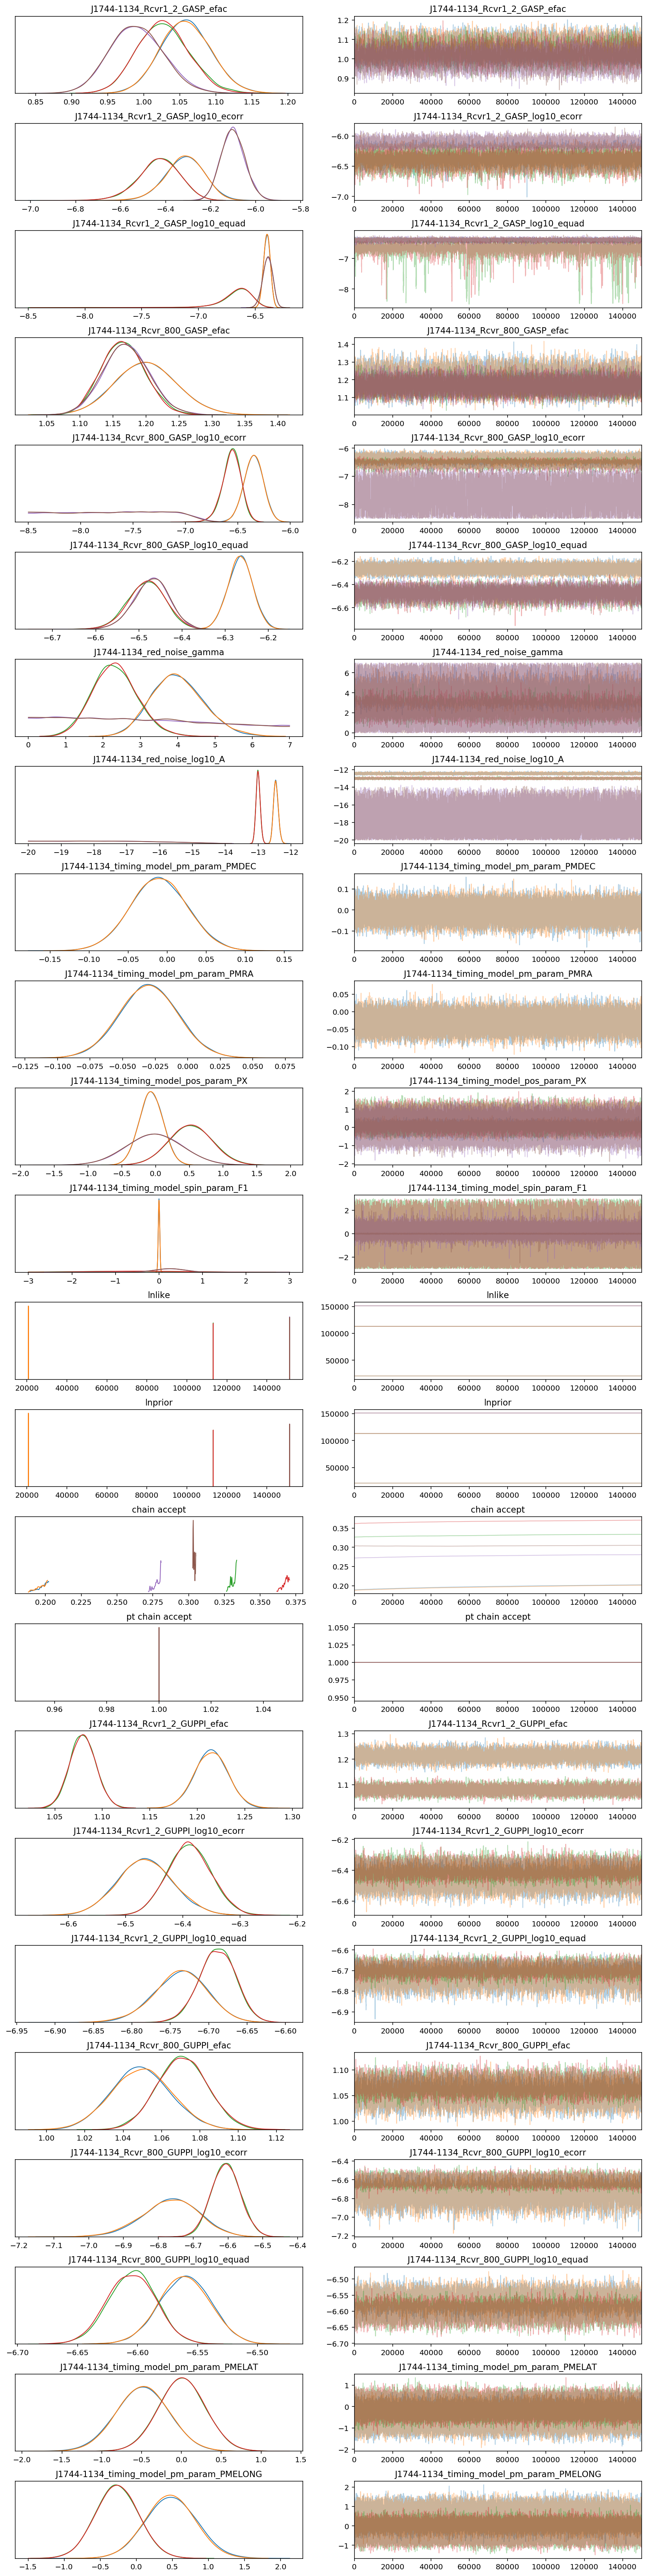

In [22]:
az.plot_trace(az_comb);

Rescaling the timing parameters to their physical values to properly compare datasets

In [23]:
def rescale_pars(chains,tmparams,pardict,dataset,old_dict=None):
    if not isinstance(chains,np.ndarray):
        chains=np.asarray(chains)
        
    if not isinstance(tmparams,np.ndarray):
        tmparams=np.array(tmparams)
        
    rescaled_chain_dict={}
    for i in range(np.shape(tmparams)[0]):
        for j,par in enumerate(tmparams[i]):
            split_string = par.split('_')
            psr_name = split_string[0]
            if 'timing' in split_string:
                og_par = split_string[-1]
                rescaled_chain = chains[i][:,j]*pardict[dataset][psr_name][og_par]['err']+\
                                    pardict[dataset][psr_name][og_par]['val']
            else:
                if psr_name in ['lnlike','lnprior', 'chain accept', 'pt chain accept']:
                    og_par = par
                    rescaled_chain = chains[i][:,j]
                else:
                    if list(par)[0] != 'J':
                        og_par = 'J' + par
                    else:
                        og_par = par
                rescaled_chain = chains[i][:,j]

            if og_par in rescaled_chain_dict.keys():
                rescaled_chain_dict[og_par] = np.concatenate((rescaled_chain_dict[og_par],[rescaled_chain]),axis=0)
            else:
                rescaled_chain_dict[og_par] = [rescaled_chain]
                
    if old_dict is not None:
        for old_key in old_dict.keys():
            if old_key in rescaled_chain_dict.keys():
                rescaled_chain_dict[old_key] = np.concatenate((rescaled_chain_dict[old_key],old_dict[old_key]),axis=0)
            else:
                rescaled_chain_dict[old_key] = old_dict[old_key]
                
            
    return rescaled_chain_dict

Have to split into datasets for variable WN
Have to separate by number of parameters, then join

In [25]:
dataset_5yr_idx = sorted(np.concatenate((chaindir_indices['uniform']['5yr'],chaindir_indices['bounded']['5yr']),axis=0))
"""
rescaled_5yr_chain_dict_1 = rescale_pars(np.asarray([chain_list[x] for x in dataset_5yr_idx[-2:]]),
                                   [tmparam_list[x] for x in dataset_5yr_idx[-2:]],pardict,'5yr')
"""
rescaled_5yr_chain_dict_comb = rescale_pars(np.asarray([chain_list[x] for x in dataset_5yr_idx]),
                                           [tmparam_list[x] for x in dataset_5yr_idx],pardict,'5yr')
az_comb_5yr_rescaled = az.convert_to_inference_data(rescaled_5yr_chain_dict_comb)

In [26]:
dataset_9yr_idx = sorted(np.concatenate((chaindir_indices['uniform']['9yr'],chaindir_indices['bounded']['9yr']),axis=0))
"""
rescaled_9yr_chain_dict_1 = rescale_pars(np.asarray([chain_list[x] for x in dataset_9yr_idx[:2]]),
                                   [tmparam_list[x] for x in dataset_9yr_idx[:2]],pardict,'9yr')
"""
rescaled_9yr_chain_dict_comb = rescale_pars(np.asarray([chain_list[x] for x in dataset_9yr_idx]),
                                   [tmparam_list[x] for x in dataset_9yr_idx],pardict,'9yr')
az_comb_9yr_rescaled = az.convert_to_inference_data(rescaled_9yr_chain_dict_comb)

In [28]:
dataset_11yr_idx = sorted(np.concatenate((chaindir_indices['uniform']['11yr'],chaindir_indices['bounded']['11yr']),axis=0))
"""
rescaled_11yr_chain_dict_1 = rescale_pars(np.asarray([chain_list[x] for x in dataset_11yr_idx[-2:]]),
                                   [tmparam_list[x] for x in dataset_11yr_idx[-2:]],pardict,'11yr')
"""
rescaled_11yr_chain_dict_comb = rescale_pars(np.asarray([chain_list[x] for x in dataset_11yr_idx]),
                                   np.asarray([tmparam_list[x] for x in dataset_11yr_idx]),
                                        pardict,'11yr')

az_comb_11yr_rescaled = az.convert_to_inference_data(rescaled_11yr_chain_dict_comb)

Combine the common parameters for the not donked up datasets

In [46]:
rescaled_chain_dict_all = {}
for param in rescaled_5yr_chain_dict_comb.keys():
    if param not in ['lnlike','lnprior', 'chain accept', 'pt chain accept']:
        if param in rescaled_9yr_chain_dict_comb.keys():
            if param in rescaled_chain_dict_all.keys():
                rescaled_chain_dict_all[param] = np.concatenate((rescaled_chain_dict_all[param],
                                                                      rescaled_9yr_chain_dict_comb[param]),axis=0)
            else:
                rescaled_chain_dict_all[param] = np.concatenate((rescaled_5yr_chain_dict_comb[param],
                                                                 rescaled_9yr_chain_dict_comb[param]),axis=0)
        if param in rescaled_11yr_chain_dict_comb.keys():
            if param in rescaled_chain_dict_all.keys():
                rescaled_chain_dict_all[param] = np.concatenate((rescaled_chain_dict_all[param],
                                                                 rescaled_11yr_chain_dict_comb[param]),axis=0)
            else:
                rescaled_chain_dict_all[param] = np.concatenate((rescaled_5yr_chain_dict_comb[param],
                                                                  rescaled_11yr_chain_dict_comb[param]),axis=0)

In [ ]:
#az.summary(az_comb_5yr_rescaled)

In [30]:
#az.summary(az_comb_9yr_rescaled)

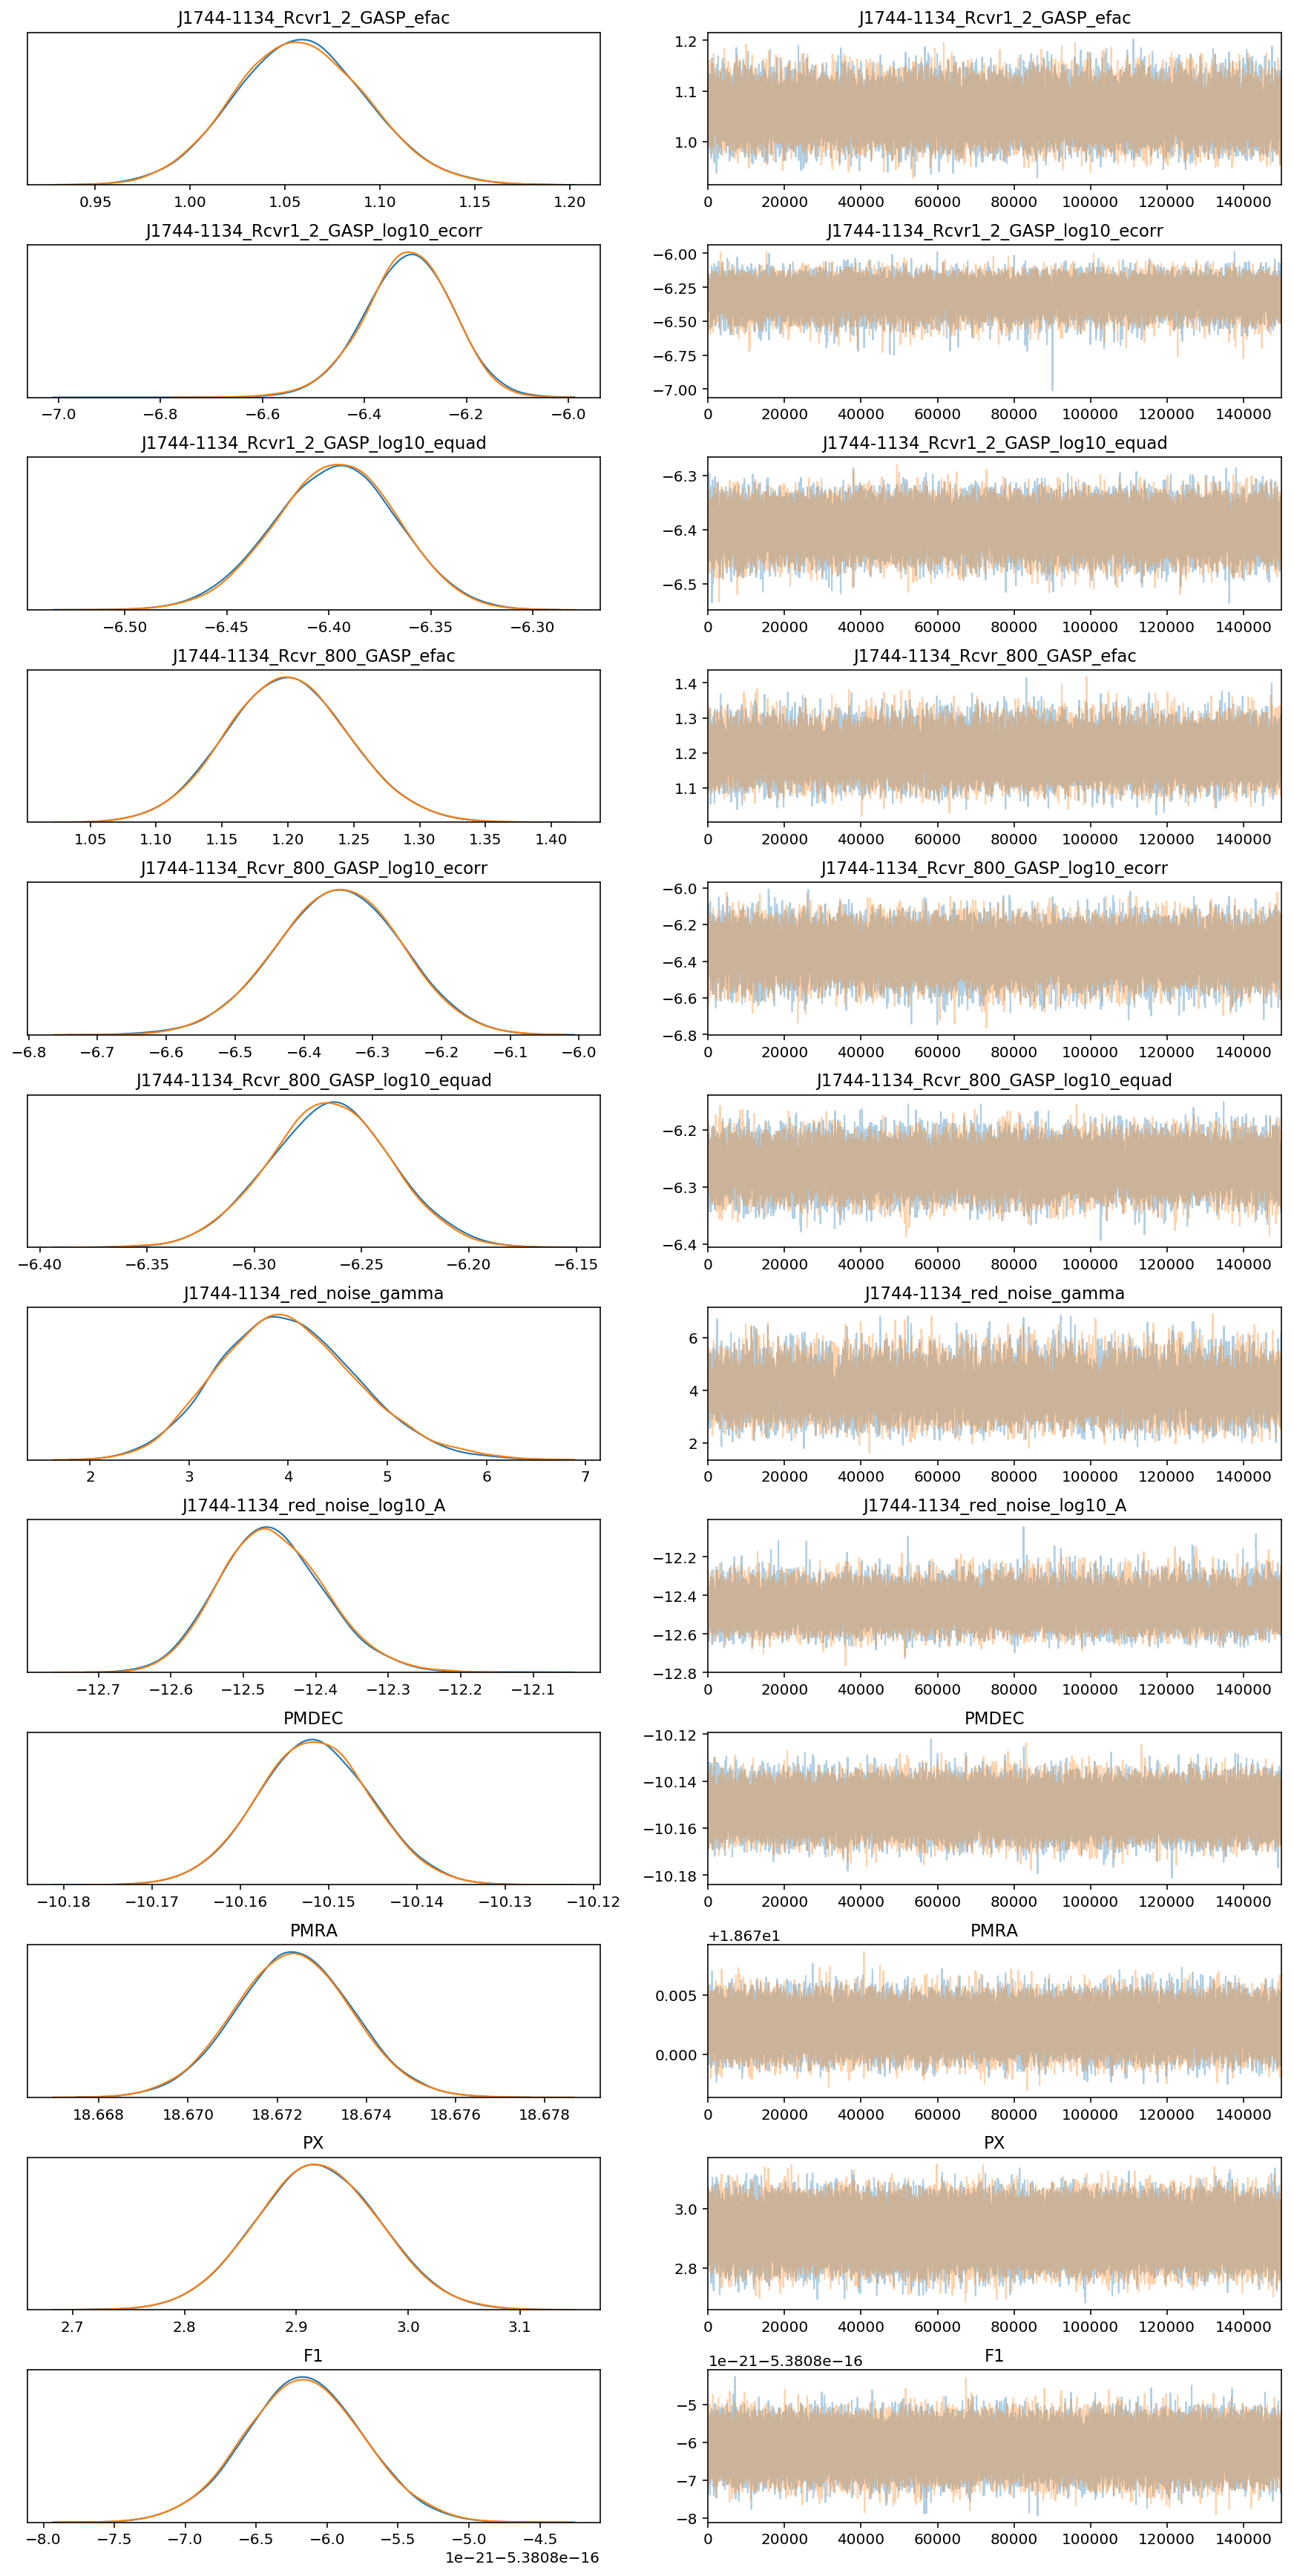

In [31]:
common_pars = []
for param in rescaled_5yr_chain_dict_comb.keys():
    if param not in ['lnlike','lnprior', 'chain accept', 'pt chain accept']:
        common_pars.append(param)
az.plot_trace(az_comb_5yr_rescaled,var_names=common_pars,plot_kwargs={'linewidth':3});

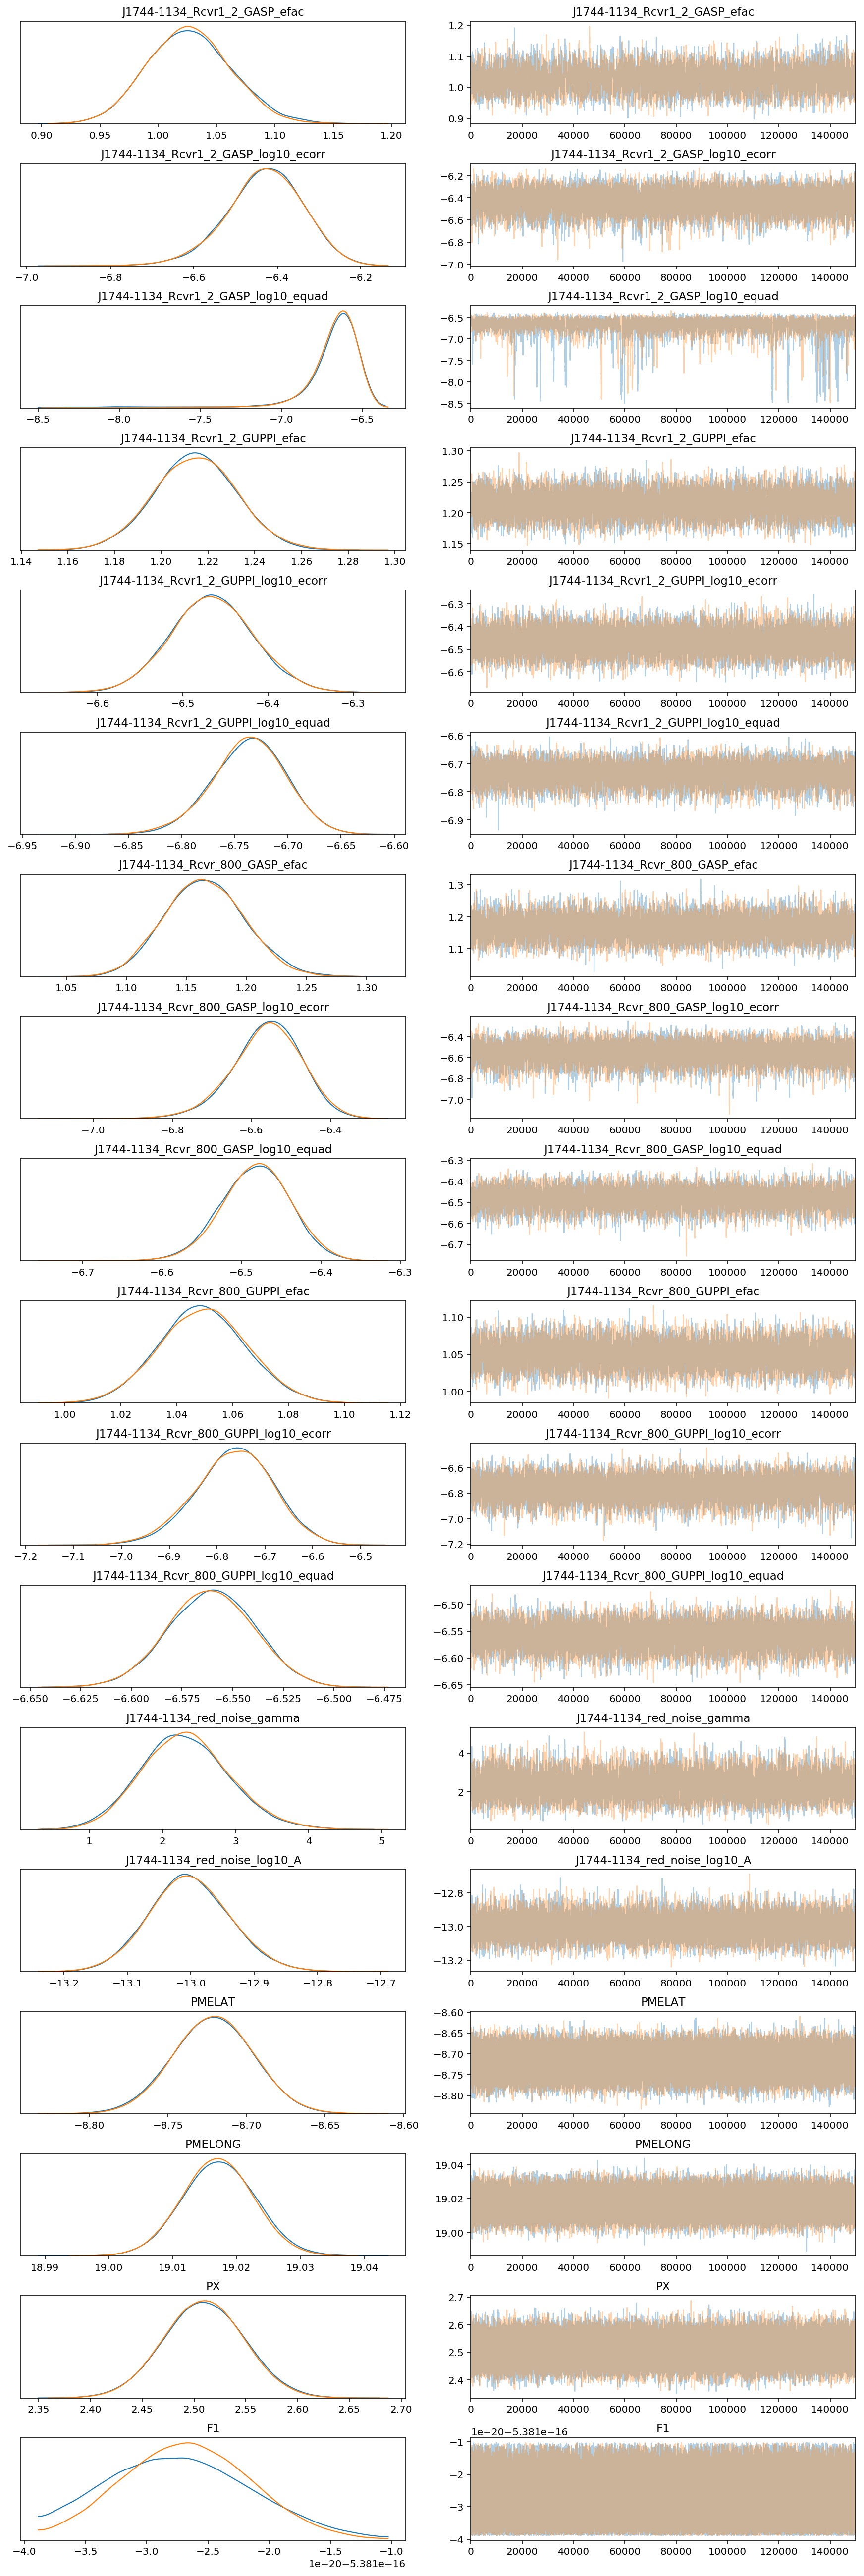

In [32]:
common_pars = []
for param in rescaled_9yr_chain_dict_comb.keys():
    if param not in ['lnlike','lnprior', 'chain accept', 'pt chain accept']:
        common_pars.append(param)
az.plot_trace(az_comb_9yr_rescaled,var_names=common_pars,plot_kwargs={'linewidth':3});

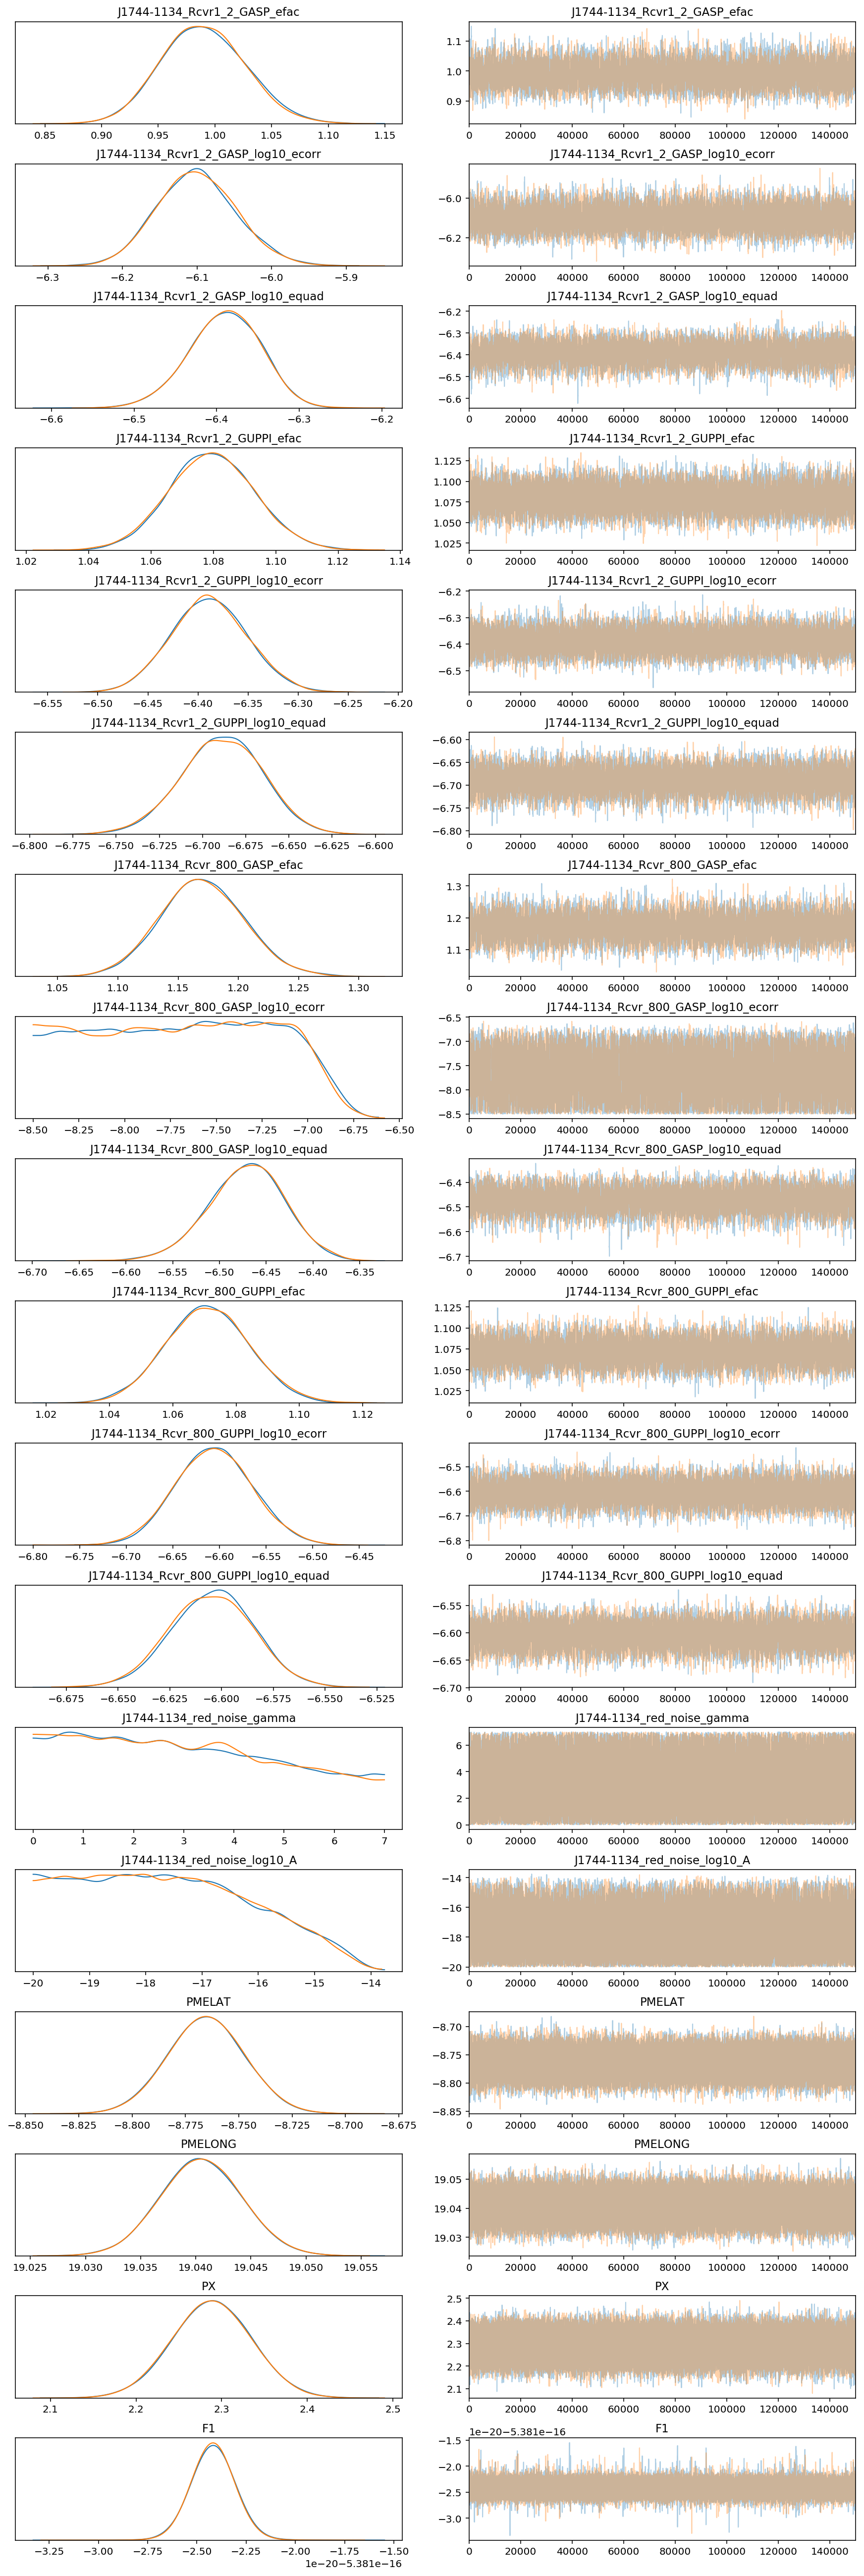

In [33]:
common_pars = []
for param in rescaled_11yr_chain_dict_comb.keys():
    if param not in ['lnlike','lnprior', 'chain accept', 'pt chain accept']:
        common_pars.append(param)
az.plot_trace(az_comb_11yr_rescaled,var_names=common_pars,plot_kwargs={'linewidth':3});

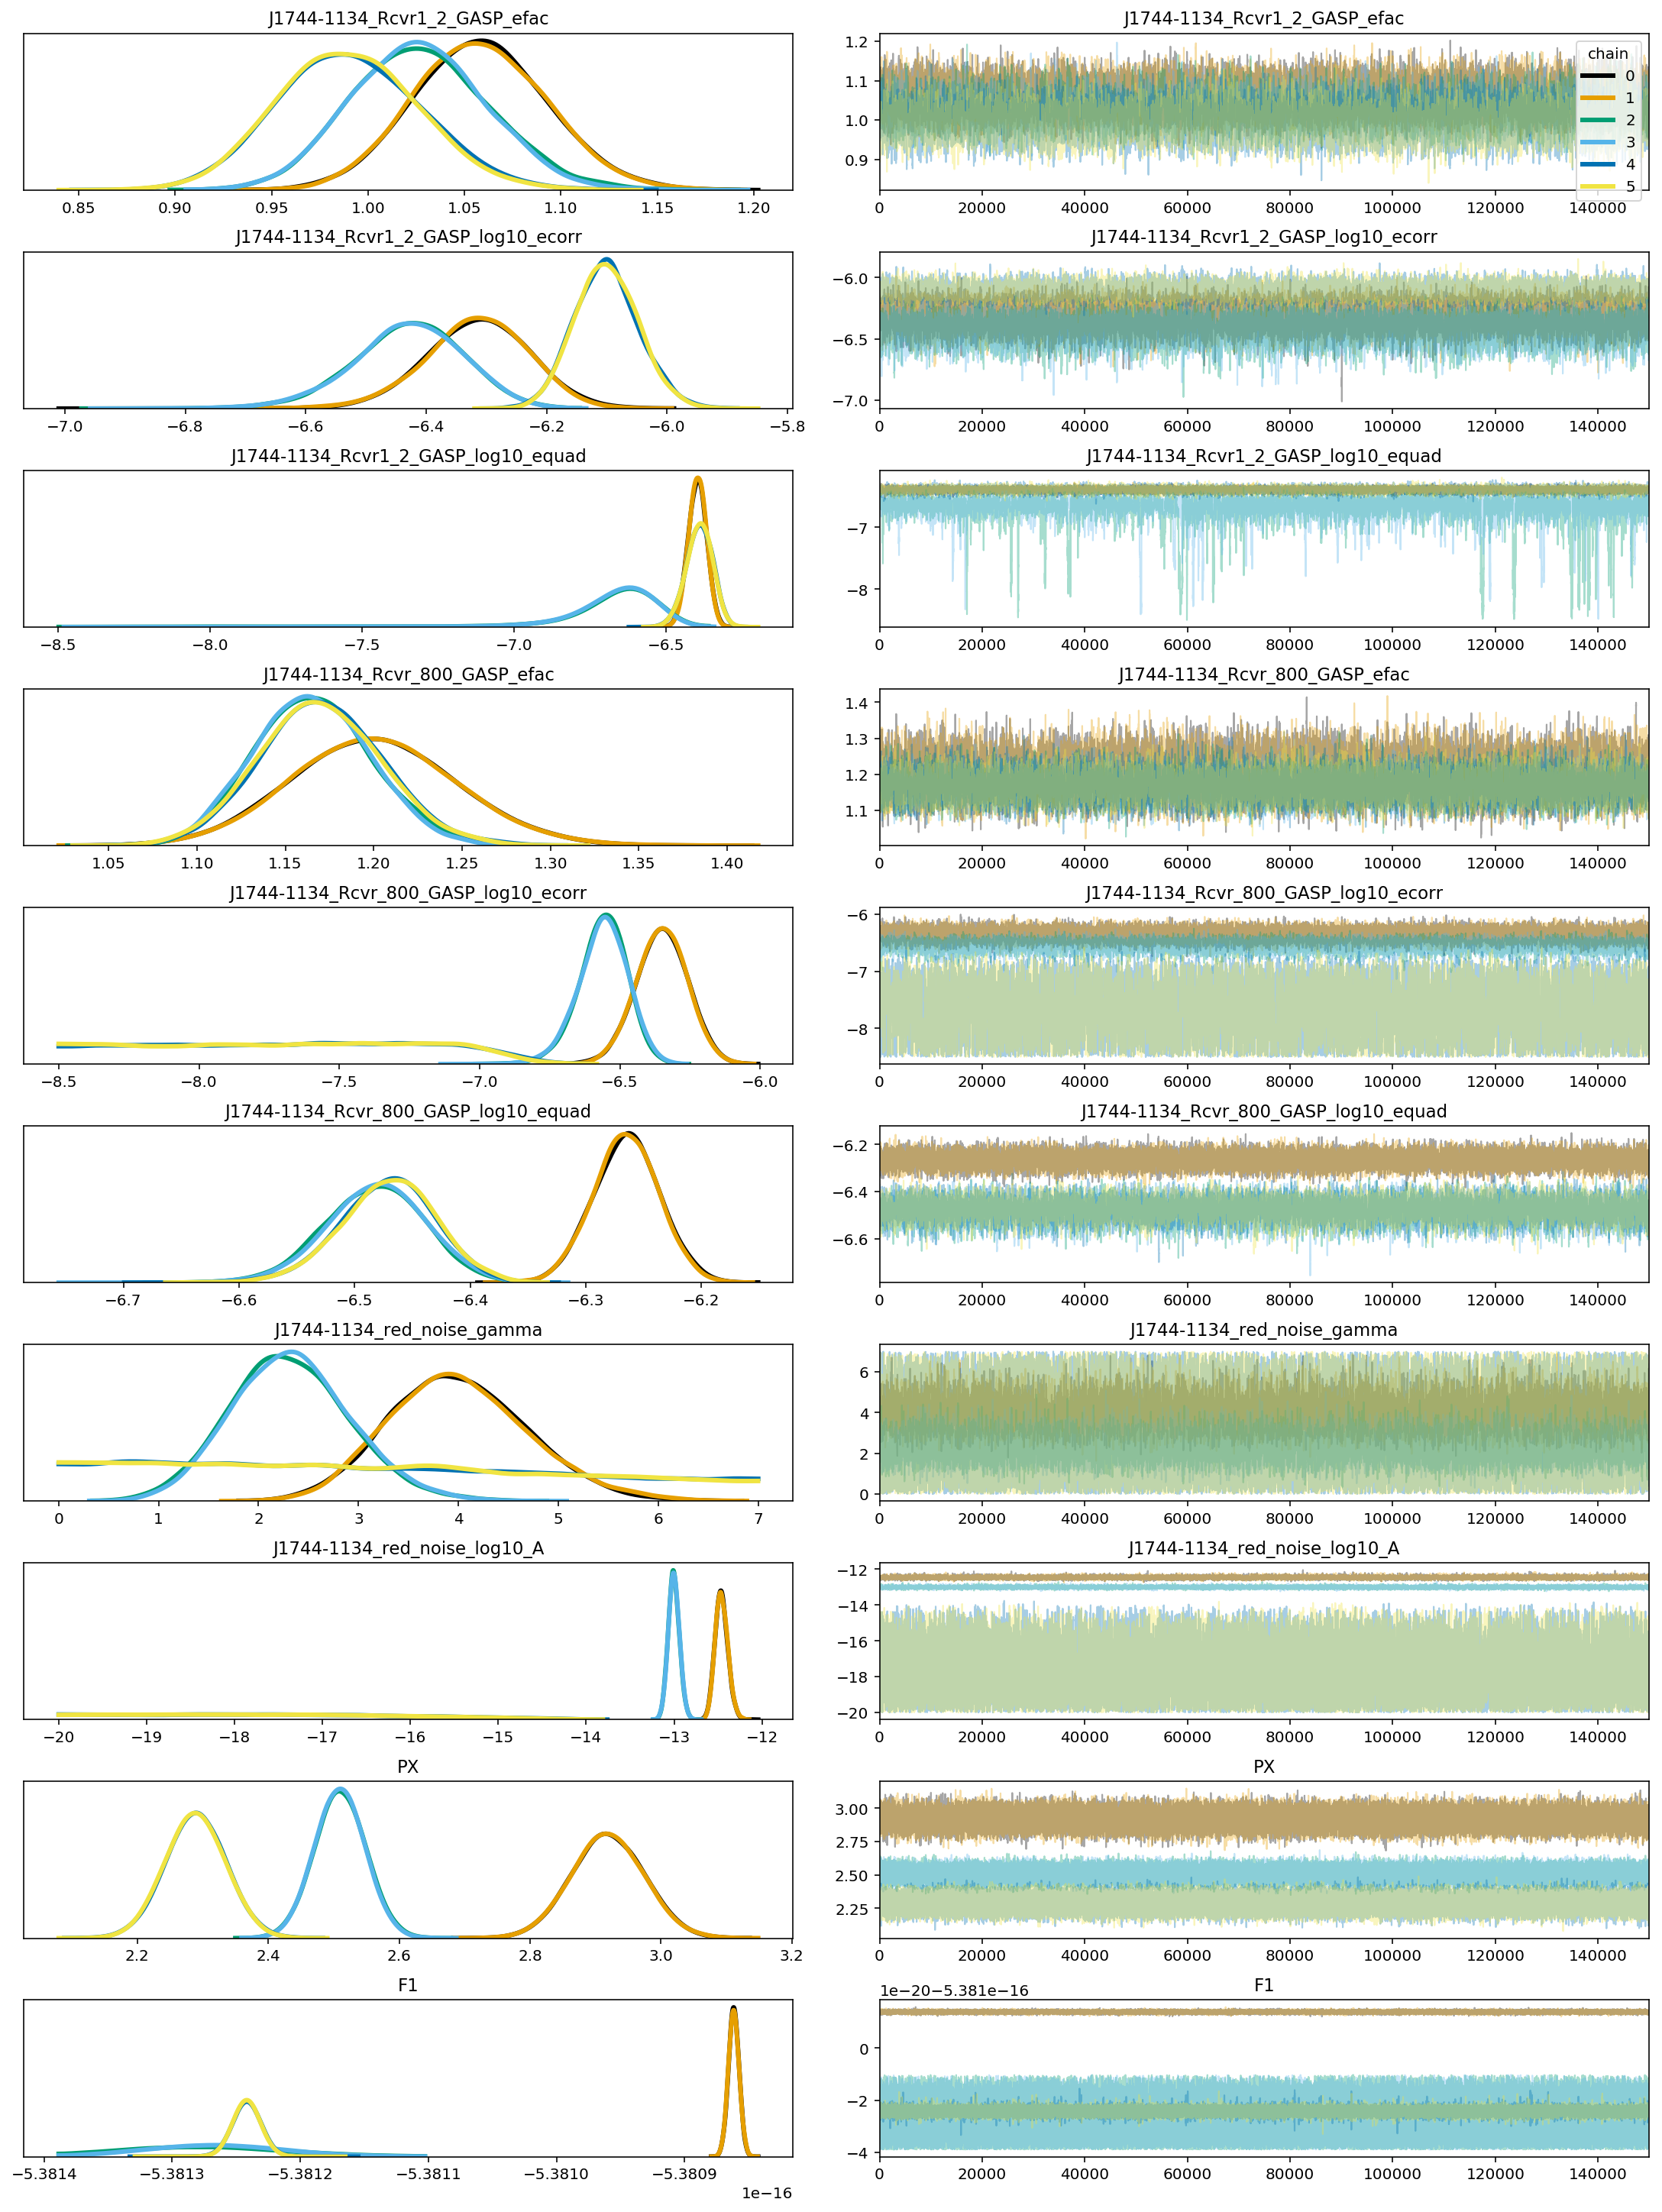

In [64]:
labels = ['5yr,uniform prior','5yr,bounded prior','9yr,bounded prior','9yr,bounded prior''11yr,uniform prior','5yr,bounded prior']
az.plot_trace(rescaled_chain_dict_all,legend=True,figsize=(15,2*len(rescaled_chain_dict_all.keys())),
             plot_kwargs={'linewidth':3},trace_kwargs={'label':labels});